In [35]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('95c03c589c246cc7b67e5f91944f5fc4/2087604_42.79_-78.40_2007.csv',header=1)

df_1 = pd.read_csv('95c03c589c246cc7b67e5f91944f5fc4/2087604_42.79_-78.40_2008.csv',header=1).drop(labels=range(720,8760),axis=0)
df = pd.concat([df,df_1],axis=0,ignore_index=True)
print(df.columns)
print(len(df))
#print the head
df.head()

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'power - DEPRECATED',
       'wind direction at 100m (deg)', 'wind speed at 100m (m/s)',
       'air temperature at 100m (C)', 'air pressure at 100m (Pa)',
       'density - DEPRECATED', 'Date'],
      dtype='object')
9480


,Year,Month,Day,Hour,Minute,power - DEPRECATED,wind direction at 100m (deg),wind speed at 100m (m/s),air temperature at 100m (C),air pressure at 100m (Pa),density - DEPRECATED,Date
0,2007,1,1,0,30,NaN,179.54,19.34,6.94,95010,NaN,1/1/07 00:00
1,2007,1,1,1,30,NaN,181.62,18.22,7.14,95030,NaN,1/1/07 01:00
2,2007,1,1,2,30,NaN,185.42,17.50,7.05,95060,NaN,1/1/07 02:00
3,2007,1,1,3,30,NaN,186.44,17.26,7.41,95030,NaN,1/1/07 03:00
4,2007,1,1,4,30,NaN,188.46,15.05,7.24,95030,NaN,1/1/07 04:00


In [114]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras
import time

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'wind speed at 100m (m/s)'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['wind speed at 100m (m/s)'][i] = data['wind speed at 100m (m/s)'][i]


#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:8760,:]
valid = dataset[8760:,:]


#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# Generate an array of the different optimizers to iterate over in a for loop
optimizer_names = ['SGD','Momentum','Nesterov', 'RMSprop','Adagrad','Adam','NAdam']
optimizer_list = ['SGD',keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=False),keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=True), 'RMSprop','Adagrad','Adam','NAdam']

# Arrays for training and validation performance
hist_acc = []
hist_val_acc = []
hist_loss = []
hist_val_loss = []
pre = np.zeros([7,720])
time_list = []

# Iterate over optimizers and train the network, using x_test and y_test as a validation set in each epoch
for name,item in zip(optimizer_names, optimizer_list):
    print("----------------------------------------------------------------------------------")
    print("Training the ANN with %s optimizer" %str(name))
    st_t = time.time()
    # predicting 720 values, using past 60 from the train data
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
        y_test.append(inputs[i,0])
    X_test,y_test = np.array(X_test), np.array(y_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=item,metrics=['accuracy'])
    seqModel = model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2,validation_data=(X_test, y_test))
    
    # Store the performance
    print(seqModel.history.keys())
    hist_loss.append(seqModel.history['loss'])
    hist_val_loss.append(seqModel.history['val_loss'])
                         
    
    wind_speed = model.predict(X_test)
    wind_speed = scaler.inverse_transform(wind_speed)
    pre[optimizer_list.index(item)] = wind_speed.reshape(1,-1)
    en_t = time.time()
    time_list.append((name,en_t-st_t))
    

----------------------------------------------------------------------------------
Training the ANN with SGD optimizer
Epoch 1/10
8700/8700 - 125s - loss: 0.0134 - accuracy: 2.2989e-04 - val_loss: 0.0089 - val_accuracy: 0.0000e+00
Epoch 2/10
8700/8700 - 153s - loss: 0.0089 - accuracy: 2.2989e-04 - val_loss: 0.0070 - val_accuracy: 0.0000e+00
Epoch 3/10
8700/8700 - 148s - loss: 0.0074 - accuracy: 2.2989e-04 - val_loss: 0.0059 - val_accuracy: 0.0000e+00
Epoch 4/10
8700/8700 - 132s - loss: 0.0065 - accuracy: 2.2989e-04 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 5/10
8700/8700 - 133s - loss: 0.0059 - accuracy: 2.2989e-04 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 6/10
8700/8700 - 130s - loss: 0.0055 - accuracy: 2.2989e-04 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 7/10
8700/8700 - 130s - loss: 0.0052 - accuracy: 2.2989e-04 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 8/10
8700/8700 - 129s - loss: 0.0050 - accuracy: 2.2989e-04 - val_loss: 0.0049 - val_accura

Epoch 4/10
8700/8700 - 135s - loss: 0.0033 - accuracy: 2.2989e-04 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 5/10
8700/8700 - 121s - loss: 0.0032 - accuracy: 2.2989e-04 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 6/10
8700/8700 - 121s - loss: 0.0032 - accuracy: 2.2989e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 7/10
8700/8700 - 120s - loss: 0.0032 - accuracy: 2.2989e-04 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 8/10
8700/8700 - 121s - loss: 0.0032 - accuracy: 2.2989e-04 - val_loss: 0.0025 - val_accuracy: 0.0000e+00
Epoch 9/10
8700/8700 - 119s - loss: 0.0032 - accuracy: 2.2989e-04 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 10/10
8700/8700 - 120s - loss: 0.0031 - accuracy: 2.2989e-04 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [98]:
rms=np.sqrt(np.mean(np.power((valid-wind_speed),2)))
rms

1.168753297154702

In [116]:
time_list

[('SGD', 1342.2507450580597),
 ('Momentum', 1439.875571012497),
 ('Nesterov', 1335.077190876007),
 ('RMSprop', 1355.0709102153778),
 ('Adagrad', 1387.5040147304535),
 ('Adam', 1506.894474029541),
 ('NAdam', 1298.5699999332428)]

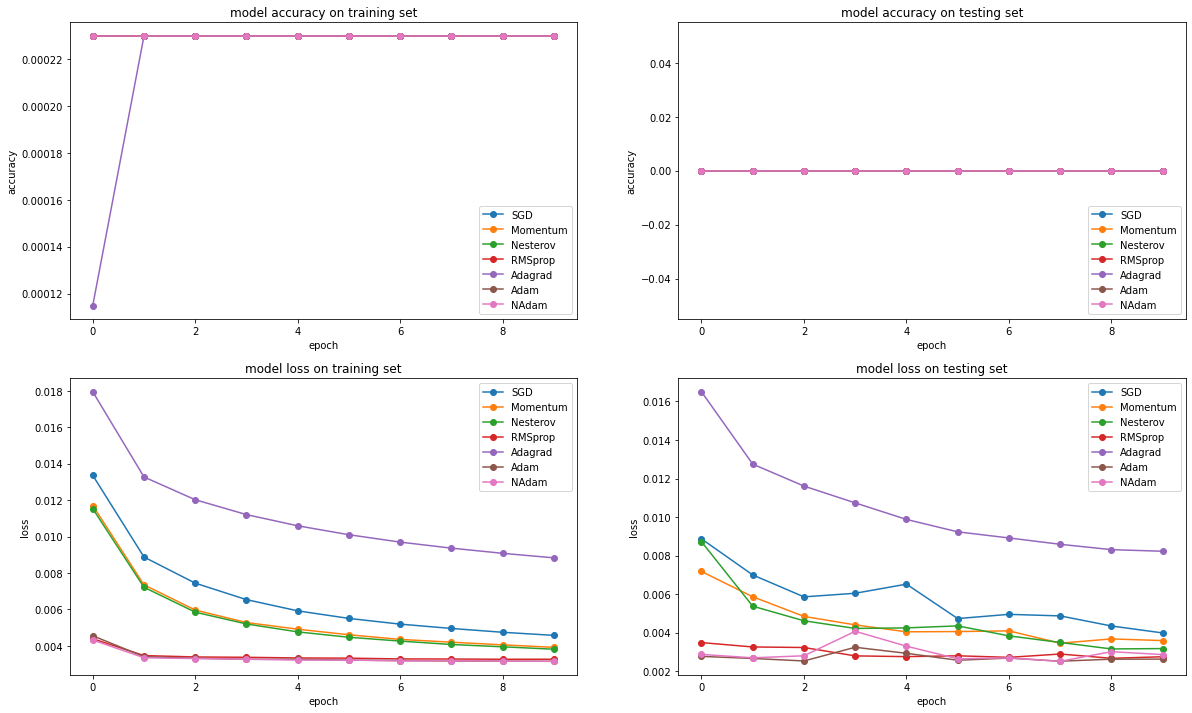

In [120]:
plt.figure(figsize=(20,12))

# summarize history for accuracy on training set
plt.subplot(221)
for i in range(len(optimizer_list)):
    plt.plot(hist_acc[i],'-o',label=str(optimizer_names[i]))
plt.title('model accuracy on training set')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

# summarize history for accuracy on test set
plt.subplot(222)
for i in range(len(optimizer_list)):
    plt.plot(hist_val_acc[i],'-o', label=str(optimizer_names[i]))
plt.title('model accuracy on testing set')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

# summarize history for loss on training set
plt.subplot(223)
for i in range(len(optimizer_list)):
    plt.plot(hist_loss[i],'-o',label=str(optimizer_names[i]))
plt.title('model loss on training set')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

# summarize history for loss on test set
plt.subplot(224)
for i in range(len(optimizer_list)):
    plt.plot(hist_val_loss[i],'-o', label=str(optimizer_names[i]))
plt.title('model loss on testing set')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')

plt.show()

<ipython-input-155-285cfa56947d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['SGD'] = pre[0]
<ipython-input-155-285cfa56947d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Momentum'] = pre[1]
<ipython-input-155-285cfa56947d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

([<matplotlib.axis.XTick at 0x7fdc011545e0>,
 <a list of 11 Text major ticklabel objects>)

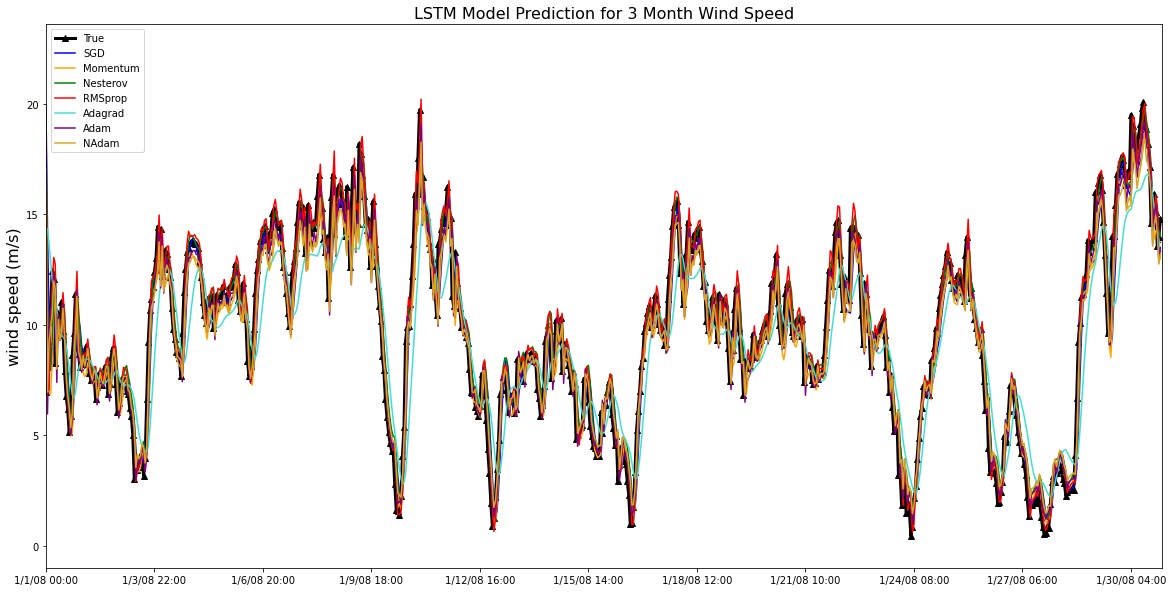

In [155]:
#for plotting
import datetime
labels = ['True','SGD','Momentum','Nesterov', 'RMSprop','Adagrad','Adam','NAdam']
marker = ['o',',',',',',',',',',',',',',']
train = new_data[:8760]
valid = new_data[8760:]
valid['SGD'] = pre[0]
valid['Momentum'] = pre[1]
valid['Nesterov'] = pre[2]
valid['RMSprop'] = pre[3]
valid['Adagrad'] = pre[4]
valid['Adam'] = pre[5]
valid['NAdam'] = pre[6]
valid['True'] = valid['wind speed at 100m (m/s)']
plt.plot(train['wind speed at 100m (m/s)'])

plt.plot(valid['True'], marker='^', label='True',mfc='black',lw=3,color='black')
plt.plot(valid['SGD'], label='SGD',color='b')
plt.plot(valid['Momentum'], label='Momentum',color='orange')
plt.plot(valid['Nesterov'], label='Nesterov',color='g')
plt.plot(valid['RMSprop'], label='RMSprop',color='r')
plt.plot(valid['Adagrad'], label='Adagrad',color='turquoise')
plt.plot(valid['Adam'], label='Adam',color='purple')
plt.plot(valid['NAdam'], label='NAdam',color='goldenrod')
plt.title('LSTM Model Prediction for 3 Month Wind Speed',fontsize=16)
plt.ylabel('wind speed (m/s)',fontsize=16)
plt.legend(fontsize='x-large')
plt.xlim(8760,9480)
plt.legend(fontsize='medium')
plt.xticks(np.arange(8760,9480, 70))

<ipython-input-148-b7ef0fbcbd3b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['SGD'] = pre[0]
<ipython-input-148-b7ef0fbcbd3b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Momentum'] = pre[1]
<ipython-input-148-b7ef0fbcbd3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

([<matplotlib.axis.XTick at 0x7fdc1392fdf0>,
 <a list of 9 Text major ticklabel objects>)

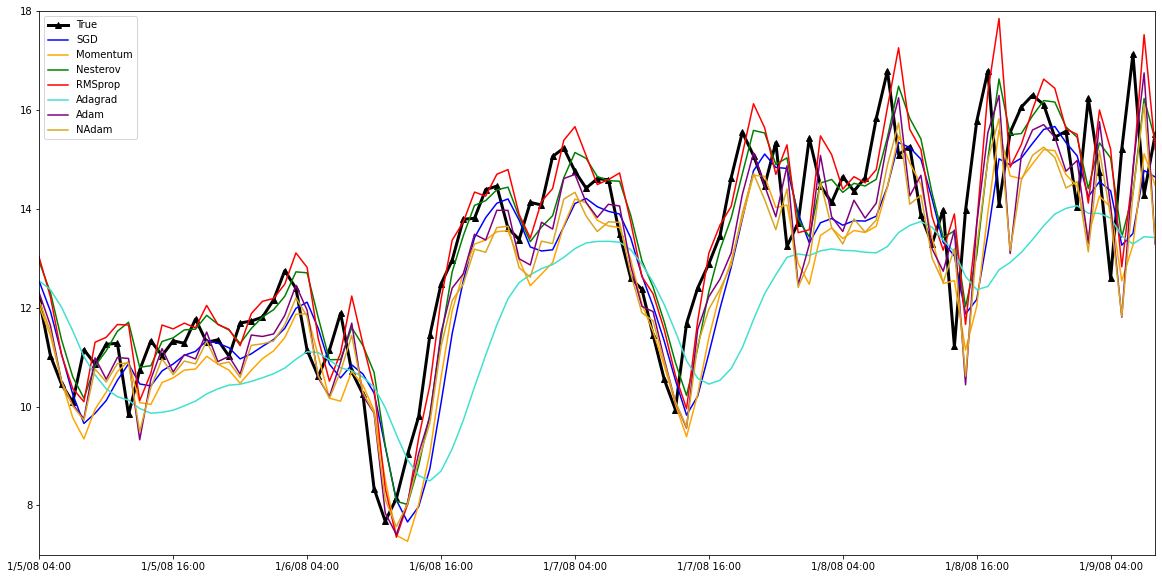

In [148]:
#for plotting
import datetime
labels = ['True','SGD','Momentum','Nesterov', 'RMSprop','Adagrad','Adam','NAdam']
marker = ['o',',',',',',',',',',',',',',']
train = new_data[:8760]
valid = new_data[8760:]
valid['SGD'] = pre[0]
valid['Momentum'] = pre[1]
valid['Nesterov'] = pre[2]
valid['RMSprop'] = pre[3]
valid['Adagrad'] = pre[4]
valid['Adam'] = pre[5]
valid['NAdam'] = pre[6]
valid['True'] = valid['wind speed at 100m (m/s)']
plt.plot(train['wind speed at 100m (m/s)'])
plt.plot(valid['True'], marker='^', label='True',mfc='black',lw=3,color='black')
plt.plot(valid['SGD'], label='SGD',color='b')
plt.plot(valid['Momentum'], label='Momentum',color='orange')
plt.plot(valid['Nesterov'], label='Nesterov',color='g')
plt.plot(valid['RMSprop'], label='RMSprop',color='r')
plt.plot(valid['Adagrad'], label='Adagrad',color='turquoise')
plt.plot(valid['Adam'], label='Adam',color='purple')
plt.plot(valid['NAdam'], label='NAdam',color='goldenrod')
plt.xlim(8860,8960)
plt.ylim(7,18)
plt.legend(fontsize='medium')
plt.xticks(np.arange(8860,8960, 12))

<ipython-input-150-4bc326171f0a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['SGD'] = pre[0]
<ipython-input-150-4bc326171f0a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Momentum'] = pre[1]
<ipython-input-150-4bc326171f0a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

([<matplotlib.axis.XTick at 0x7fdc192e4f10>,
 <a list of 8 Text major ticklabel objects>)

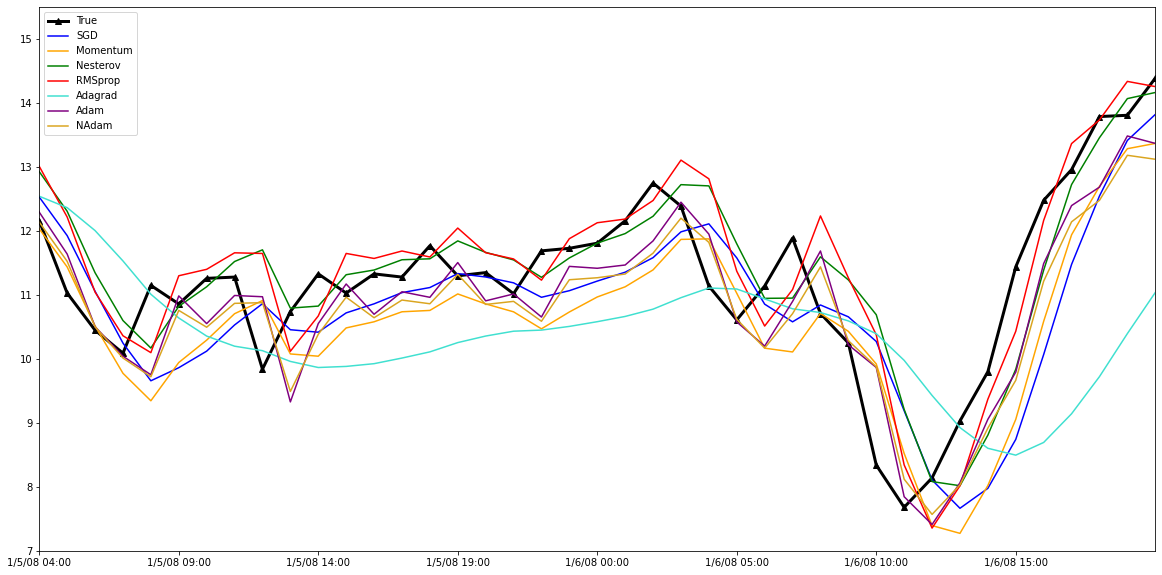

In [150]:
#for plotting
import datetime
labels = ['True','SGD','Momentum','Nesterov', 'RMSprop','Adagrad','Adam','NAdam']
marker = ['o',',',',',',',',',',',',',',']
train = new_data[:8760]
valid = new_data[8760:]
valid['SGD'] = pre[0]
valid['Momentum'] = pre[1]
valid['Nesterov'] = pre[2]
valid['RMSprop'] = pre[3]
valid['Adagrad'] = pre[4]
valid['Adam'] = pre[5]
valid['NAdam'] = pre[6]
valid['True'] = valid['wind speed at 100m (m/s)']
plt.plot(train['wind speed at 100m (m/s)'])
plt.plot(valid['True'], marker='^', label='True',mfc='black',lw=3,color='black')
plt.plot(valid['SGD'], label='SGD',color='b')
plt.plot(valid['Momentum'], label='Momentum',color='orange')
plt.plot(valid['Nesterov'], label='Nesterov',color='g')
plt.plot(valid['RMSprop'], label='RMSprop',color='r')
plt.plot(valid['Adagrad'], label='Adagrad',color='turquoise')
plt.plot(valid['Adam'], label='Adam',color='purple')
plt.plot(valid['NAdam'], label='NAdam',color='goldenrod')
plt.xlim(8860,8900)
plt.ylim(7,15.5)
plt.legend(fontsize='medium')
plt.xticks(np.arange(8860,8900, 5))

<ipython-input-153-da587e63a56c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['SGD'] = pre[0]
<ipython-input-153-da587e63a56c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Momentum'] = pre[1]
<ipython-input-153-da587e63a56c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

([<matplotlib.axis.XTick at 0x7fdc13aea0d0>,
 <a list of 4 Text major ticklabel objects>)

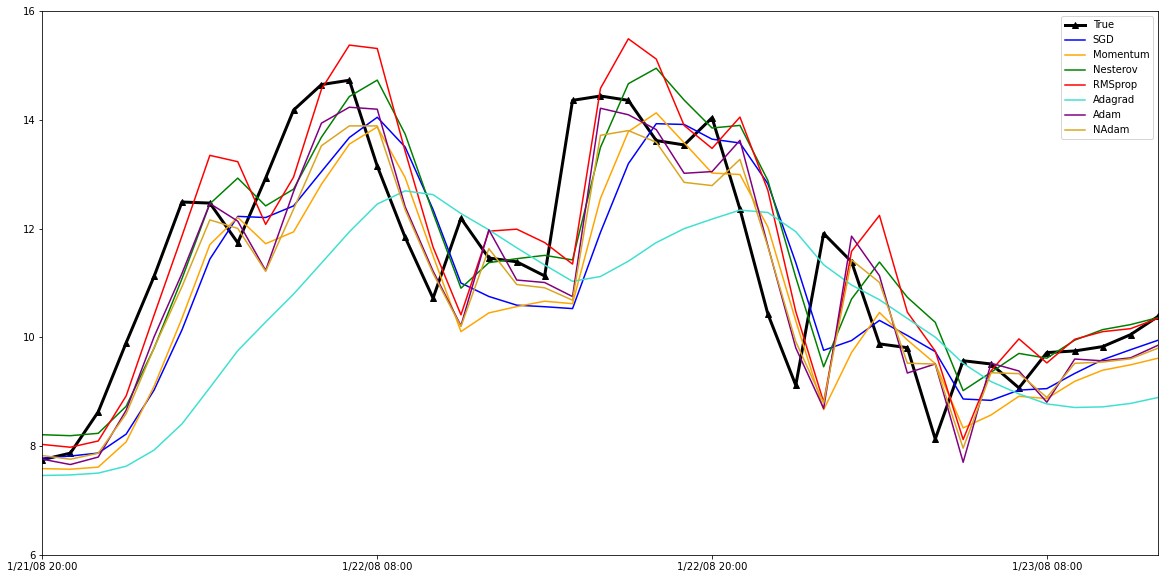

In [153]:
#for plotting
import datetime
labels = ['True','SGD','Momentum','Nesterov', 'RMSprop','Adagrad','Adam','NAdam']
marker = ['o',',',',',',',',',',',',',',']
train = new_data[:8760]
valid = new_data[8760:]
valid['SGD'] = pre[0]
valid['Momentum'] = pre[1]
valid['Nesterov'] = pre[2]
valid['RMSprop'] = pre[3]
valid['Adagrad'] = pre[4]
valid['Adam'] = pre[5]
valid['NAdam'] = pre[6]
valid['True'] = valid['wind speed at 100m (m/s)']
plt.plot(train['wind speed at 100m (m/s)'])
plt.plot(valid['True'], marker='^', label='True',mfc='black',lw=3,color='black')
plt.plot(valid['SGD'], label='SGD',color='b')
plt.plot(valid['Momentum'], label='Momentum',color='orange')
plt.plot(valid['Nesterov'], label='Nesterov',color='g')
plt.plot(valid['RMSprop'], label='RMSprop',color='r')
plt.plot(valid['Adagrad'], label='Adagrad',color='turquoise')
plt.plot(valid['Adam'], label='Adam',color='purple')
plt.plot(valid['NAdam'], label='NAdam',color='goldenrod')
plt.xlim(9260,9300)
plt.ylim(6,16)
plt.legend(fontsize='medium')
plt.xticks(np.arange(9260,9300, 12))

In [136]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def bias_S(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sum(y_true-y_pred)/len(y_true)

In [138]:
from sklearn.metrics import mean_squared_error
true = valid['True'].to_numpy()
rmse_list = []
mape_list = []
bias_list = []
rmse_1 = mean_squared_error(true, pre[0],squared='False')
rmse_list.append(rmse_1)
rmse_2 = mean_squared_error(true, pre[1],squared='False')
rmse_list.append(rmse_2)
rmse_3 = mean_squared_error(true, pre[2],squared='False')
rmse_list.append(rmse_3)
rmse_4 = mean_squared_error(true, pre[3],squared='False')
rmse_list.append(rmse_4)
rmse_5 = mean_squared_error(true, pre[4],squared='False')
rmse_list.append(rmse_5)
rmse_6 = mean_squared_error(true, pre[5],squared='False')
rmse_list.append(rmse_6)
rmse_7 = mean_squared_error(true, pre[6],squared='False')
rmse_list.append(rmse_7)

mape_1 = mean_absolute_percentage_error(true, pre[0])
mape_list.append(mape_1)
mape_2 = mean_absolute_percentage_error(true, pre[1])
mape_list.append(mape_2)
mape_3 = mean_absolute_percentage_error(true, pre[2])
mape_list.append(mape_3)
mape_4 = mean_absolute_percentage_error(true, pre[3])
mape_list.append(mape_4)
mape_5 = mean_absolute_percentage_error(true, pre[4])
mape_list.append(mape_5)
mape_6 = mean_absolute_percentage_error(true, pre[5])
mape_list.append(mape_6)
mape_7 = mean_absolute_percentage_error(true, pre[6])
mape_list.append(mape_7)

b_1 = bias_S(true, pre[0])
bias_list.append(b_1)
b_2 = bias_S(true, pre[1])
bias_list.append(b_2)
b_3 = bias_S(true, pre[2])
bias_list.append(b_3)
b_4 = bias_S(true, pre[3])
bias_list.append(b_4)
b_5 = bias_S(true, pre[4])
bias_list.append(b_5)
b_6 = bias_S(true, pre[5])
bias_list.append(b_6)
b_7 = bias_S(true, pre[6])
bias_list.append(b_7)

print(rmse_list)
print(mape_list)
print(bias_list)

[1.9882068571872553, 1.7899441320120755, 1.5830424120370916, 1.3716036763105872, 4.104373905556699, 1.3099036908583237, 1.42745636618893]
[15.687239881686747, 14.016509349298714, 15.216944612271629, 11.909028304336687, 25.53661469839335, 12.131059404318654, 13.823223658948322]
[0.20712074585093396, 0.42917320675982357, -0.26944251874420366, -0.23936889174249426, 0.4756670428382026, 0.17771706297000248, 0.22910494354698396]


In [156]:
print(time_list)

[('SGD', 1342.2507450580597), ('Momentum', 1439.875571012497), ('Nesterov', 1335.077190876007), ('RMSprop', 1355.0709102153778), ('Adagrad', 1387.5040147304535), ('Adam', 1506.894474029541), ('NAdam', 1298.5699999332428)]
